In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
import copy

from scipy.spatial.distance import cdist

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings('ignore')

from utils import *

from sklearn.metrics import f1_score

/home/tomas/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## read data as a dictionary with each subject as a different key
## the sessions are included as a column in each dataframe
pathData = Path(r'./TrainingData')
dctData = read_data(pathData)

In [3]:
## upsample labels using nearest neighbor
dctUps = upsampleData(dctData)

In [4]:
## count number of timesteps for each session of each subject
dctClass = {f'subject_{k+1}':pd.DataFrame(index = range(1, 9), columns = range(0, 4), data = 0) for k in range(8)}
for k in dctUps.keys():
    dfs = dctUps[k]
    for s in dfs['session'].unique():
        dfss = dfs[dfs['session'] == s]
        aux = dfss['class'].value_counts().sort_index()
        dctClass[k].loc[s, aux.index] = aux.values

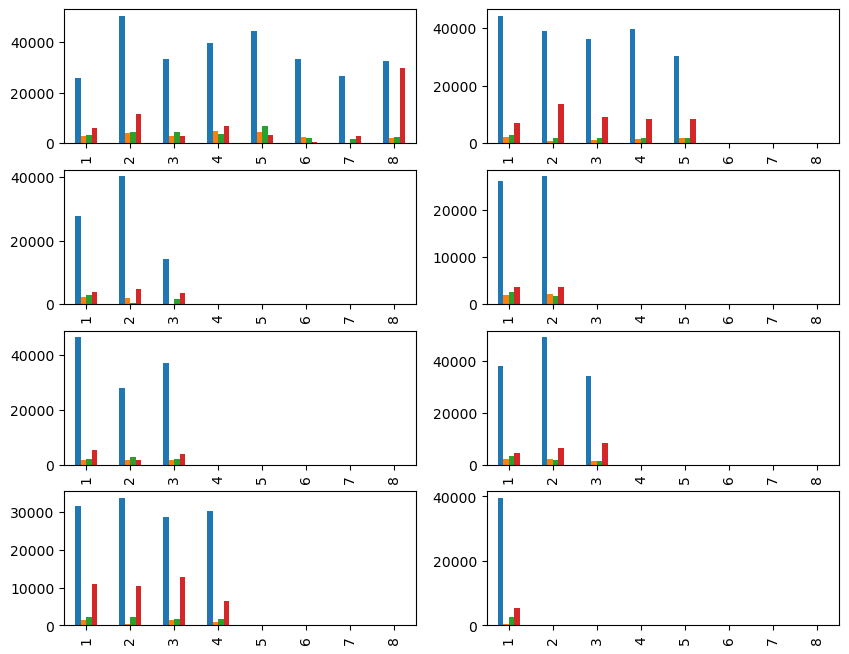

In [6]:
fig, ax = plt.subplots(figsize = (10, 8), nrows = 4, ncols = 2)
for ik, k in enumerate(dctClass.keys()):
    axs = ax.flatten()[ik]
    dctClass[k].plot.bar(ax = axs, legend = False)

In [5]:
def balanceData(dct, threshold = 2):

    dctBal = {f'subject_{k+1}':pd.DataFrame(index = range(1, 9), columns = range(0, 4), data = 0) for k in range(8)}

    for k in dctBal.keys():

        for i in dct[k].index:
            aux = dct[k].loc[i, :]
            aux2 = aux.sort_values(ascending = False)
            aux2.iloc[0] = aux2.iloc[1]

            if aux2.iloc[1] > threshold * aux2.iloc[2]:
                aux2.iloc[0] = threshold * aux2.iloc[2]
                aux2.iloc[1] = threshold * aux2.iloc[2]

            dctBal[k].loc[i, aux2.index] = aux2.values
    return dctBal

In [6]:
## get the number of instances for each to make the dataset balanced
## the first and second more frequents per session and individual are set to two times
## the third class in case they are larger. The mode is set as the same of the second 
## more repeated class
dctClassBal = balanceData(dctClass, 1.5)

In [31]:
## randomly select values for the 2 mode classes to match the dctClassBal
dctUpsBal = {}
for k in dctUps.keys():
    dfk =  dctUps[k]
    out2 = []
    for s in dfk['session'].unique():
        dfks = dfk[dfk['session'] == s]

        nvalAll = dctClass[k].loc[s, :]
        nvalBall = dctClassBal[k].loc[s, :]
        
        out = []
        for c in nvalAll.index:
            dfksc = dfks[dfks['class'] == c]
            dfkscBal = dfks.sample(nvalBall.loc[c]).sort_index()
            out.append(dfkscBal)
        dfout = pd.concat(out).sort_index()
        out2.append(dfout)
    dctUpsBal[k] = pd.concat(out2)

In [50]:
## duplicate upsampled dictionary but with flags for the windows of each class in each session
## for each subject

wlength = 100
overlapping = 20
windows_size = []

dctSt = {}
for k in dctUpsBal.keys():
    df = dctUpsBal[k]
    list2 = []
    ## loop through sessions
    for s in df['session'].unique():
        dfs = df[df['session'] == s]
        d = 0
        for i in range(0, len(dfs) - overlapping, wlength - overlapping):
            dfss = dfs.iloc[i:i + wlength]
            list1 = []
            for ic, c in enumerate(dfss.columns[:6]):
                dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                list1.extend(dummy)
            list1.append(int(dfss['class'].mode().iloc[0]))
            list2.append(list1)
    dctSt[k] = pd.DataFrame(data = list2)

In [52]:
dfsum_bal = []
for key in dctClassBal.keys():
    dfsum_bal.append(dctClassBal[key].sum())

dfsum_bal = pd.DataFrame(index = dctClassBal.keys(), columns = dctClassBal['subject_1'].columns, data = dfsum_bal)
weights_bal = (dfsum_bal.sum()/dfsum_bal.sum().sum()).values
print(weights_bal)

[0.31823021 0.16698724 0.21978467 0.29499788]


## Model 05

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(in_features = 66, out_features = 66*4)
    self.bn1 = nn.BatchNorm1d(num_features = 66*4)
    self.fc2 = nn.Linear(in_features = 66*4, out_features = 66*8)
    self.bn2 = nn.BatchNorm1d(num_features = 66*8)
    self.fc3 = nn.Linear(in_features = 66*8, out_features = 66*4)
    self.bn3 = nn.BatchNorm1d(num_features = 66*4)
    self.fc4 = nn.Linear(in_features = 66*4, out_features = 66*2)
    self.bn4 = nn.BatchNorm1d(num_features = 66*2)
    self.fc5 = nn.Linear(in_features = 66*2, out_features = 66)
    self.bn5 = nn.BatchNorm1d(num_features = 66)
    self.fc6 = nn.Linear(in_features = 66, out_features = 32)
    self.bn6 = nn.BatchNorm1d(num_features = 32)
    self.fc7 = nn.Linear(in_features = 32, out_features = 4)
    self.dout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.bn1(x)
    x = self.dout(x)

    x = self.fc2(x)
    x = F.relu(x)
    x = self.bn2(x)
    x = self.dout(x)

    x = self.fc3(x)
    x = F.relu(x)
    x = self.bn3(x)
    x = self.dout(x)

    x = self.fc4(x)
    x = F.relu(x)
    x = self.bn4(x)
    x = self.dout(x)

    x = self.fc5(x)
    x = F.relu(x)
    x = self.bn5(x)
    x = self.dout(x)

    x = self.fc6(x)
    x = F.relu(x)
    x = self.bn6(x)
    x = self.dout(x)
    
    x = self.fc7(x)
    x = F.softmax(x, dim = 1)

    return x

In [8]:
# Creating a wrapper so we have the same interface for all the methods
class NetWrapper:
  def __init__(self, epochs, lrate, dev, w):
    self.model = Net()
    if w != None:
      self.loss = nn.CrossEntropyLoss(w)
    else:
      self.loss = nn.CrossEntropyLoss()
      
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lrate)
    self.device = dev
    self.model.to(self.device)
    self.epochs = epochs
    self.history = {'train_loss': [], 'test_loss': []}
    self.min_loss = np.inf
    self.best_weights = None

  def fit(self, X_train, Y_train, X_test, Y_test):
    
    for t in range(self.epochs):

        ########### Training
        self.model.train()
        self.optimizer.zero_grad()
        X_train2 = torch.from_numpy(X_train).to(torch.float32).to(device)
        Y_pred = self.model(X_train2)#.argmax(axis = 2)
        # Y_train_b = torch.squeeze(Y_train_b, 1)
        ## compute loss
        Y_train2 = torch.from_numpy(Y_train).to(device)
        loss = self.loss(Y_pred, Y_train2)
        loss_val = float(loss.cpu().detach().numpy())
        ## backward propagation
        loss.backward()
        self.optimizer.step()
        self.history[r'train_loss'].append(loss_val)

        ########### Evaluation
        self.model.eval()
        X_test2 = torch.from_numpy(X_test).to(torch.float32).to(device)
        Y_pred = self.model(X_test2)
        ## compute loss
        Y_test2 = torch.from_numpy(Y_test).to(device)
        loss = self.loss(Y_pred, Y_test2)
        loss_val = float(loss.cpu().detach().numpy())
        self.history[r'test_loss'].append(loss_val)

        if loss < self.min_loss:
          self.min_loss = loss
          self.best_weights = copy.deepcopy(self.model.state_dict())

        if t%1000 == 0:
          a = self.history[f'train_loss'][t]
          b = self.history[f'test_loss'][t]
        
          print(f'Epoch {t}/{self.epochs}. Training loss: {a:0.3f} - Validation loss: {b:0.3f}')
    
    dfhist = pd.DataFrame.from_dict(self.history)

    return dfhist, self.min_loss, self.best_weights

  def predict(self, X):
    X = torch.from_numpy(X).float().to(self.device)

    pred = self.model(X)
    pred = pred.cpu().detach().numpy()

    return pred

*************************   Validation with subject 6   *************************

Epoch 0/10000. Training loss: 1.398 - Validation loss: 1.387
Epoch 1000/10000. Training loss: 0.801 - Validation loss: 0.964
Epoch 2000/10000. Training loss: 0.764 - Validation loss: 0.922
Epoch 3000/10000. Training loss: 0.756 - Validation loss: 0.908
Epoch 4000/10000. Training loss: 0.753 - Validation loss: 0.889
Epoch 5000/10000. Training loss: 0.751 - Validation loss: 0.913
Epoch 6000/10000. Training loss: 0.750 - Validation loss: 0.905
Epoch 7000/10000. Training loss: 0.750 - Validation loss: 0.886
Epoch 8000/10000. Training loss: 0.750 - Validation loss: 0.912
Epoch 9000/10000. Training loss: 0.749 - Validation loss: 0.902


Text(0.5, 1.0, 'F1 score: 0.764')

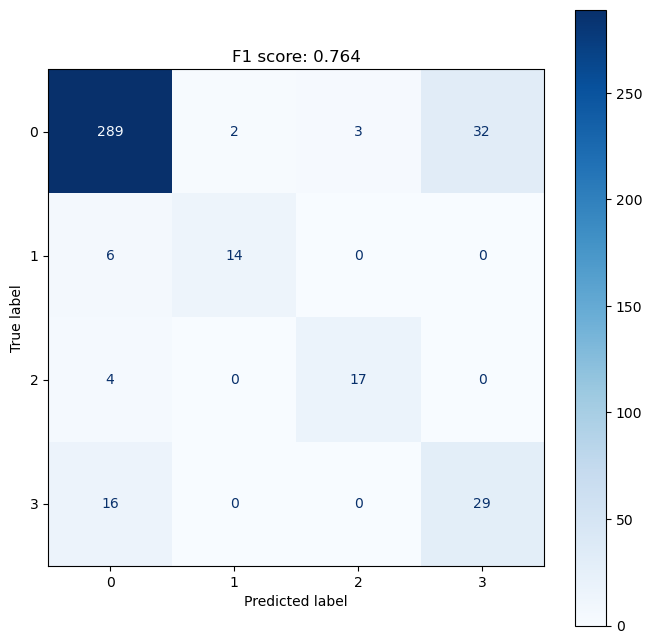

In [55]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

# for i in range(8):
i = 6
keyval = f'subject_{i}'
df_val = dctSt[keyval]

df_tr = []
for k in dctSt.keys():
  if k != keyval:
    df_tr.append(dctSt[k])
df_tr = pd.concat(df_tr)

Xtr = df_tr.iloc[:, :-1]
ytr = df_tr.iloc[:, -1]

Xvl = df_val.iloc[:, :-1] 
yvl = df_val.iloc[:, -1]

scaler = StandardScaler()
Xtr_sc = scaler.fit_transform(Xtr.values)
Xvl_sc = scaler.transform(Xvl.values)

print(f'*************************   Validation with subject {i}   *************************\n')
net = NetWrapper(10_000, learning_rate, device, None)
dfhist, minLoss, bestModel = net.fit(Xtr_sc, ytr.values, Xvl_sc, yvl.values)

pred = net.predict(Xvl_sc).argmax(axis = 1)
m = confusion_matrix(yvl.values, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=m)
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax,  cmap = plt.cm.Blues)
ax.set_title(f"F1 score: {f1_score(pred, yvl.values, average='macro'):0.3f}")

Different balace threshold

In [56]:
dctClassBal = balanceData(dctClass, 1)

## randomly select values for the 2 mode classes to match the dctClassBal
dctUpsBal = {}
for k in dctUps.keys():
    dfk =  dctUps[k]
    out2 = []
    for s in dfk['session'].unique():
        dfks = dfk[dfk['session'] == s]

        nvalAll = dctClass[k].loc[s, :]
        nvalBall = dctClassBal[k].loc[s, :]
        
        out = []
        for c in nvalAll.index:
            dfksc = dfks[dfks['class'] == c]
            dfkscBal = dfks.sample(nvalBall.loc[c]).sort_index()
            out.append(dfkscBal)
        dfout = pd.concat(out).sort_index()
        out2.append(dfout)
    dctUpsBal[k] = pd.concat(out2)

## duplicate upsampled dictionary but with flags for the windows of each class in each session
## for each subject

wlength = 100
overlapping = 20
windows_size = []

dctSt = {}
for k in dctUpsBal.keys():
    df = dctUpsBal[k]
    list2 = []
    ## loop through sessions
    for s in df['session'].unique():
        dfs = df[df['session'] == s]
        d = 0
        for i in range(0, len(dfs) - overlapping, wlength - overlapping):
            dfss = dfs.iloc[i:i + wlength]
            list1 = []
            for ic, c in enumerate(dfss.columns[:6]):
                dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                list1.extend(dummy)
            list1.append(int(dfss['class'].mode().iloc[0]))
            list2.append(list1)
    dctSt[k] = pd.DataFrame(data = list2)

dfsum_bal = []
for key in dctClassBal.keys():
    dfsum_bal.append(dctClassBal[key].sum())

dfsum_bal = pd.DataFrame(index = dctClassBal.keys(), columns = dctClassBal['subject_1'].columns, data = dfsum_bal)
weights_bal = (dfsum_bal.sum()/dfsum_bal.sum().sum()).values
print(weights_bal)



[0.27214691 0.20851909 0.25846905 0.26086495]


*************************   Validation with subject 6   *************************

Epoch 0/10000. Training loss: 1.392 - Validation loss: 1.377
Epoch 1000/10000. Training loss: 0.786 - Validation loss: 0.936
Epoch 2000/10000. Training loss: 0.760 - Validation loss: 0.894
Epoch 3000/10000. Training loss: 0.754 - Validation loss: 0.915
Epoch 4000/10000. Training loss: 0.751 - Validation loss: 0.905
Epoch 5000/10000. Training loss: 0.750 - Validation loss: 0.910
Epoch 6000/10000. Training loss: 0.750 - Validation loss: 0.907
Epoch 7000/10000. Training loss: 0.750 - Validation loss: 0.904
Epoch 8000/10000. Training loss: 0.748 - Validation loss: 0.901
Epoch 9000/10000. Training loss: 0.749 - Validation loss: 0.898


Text(0.5, 1.0, 'F1 score: 0.740')

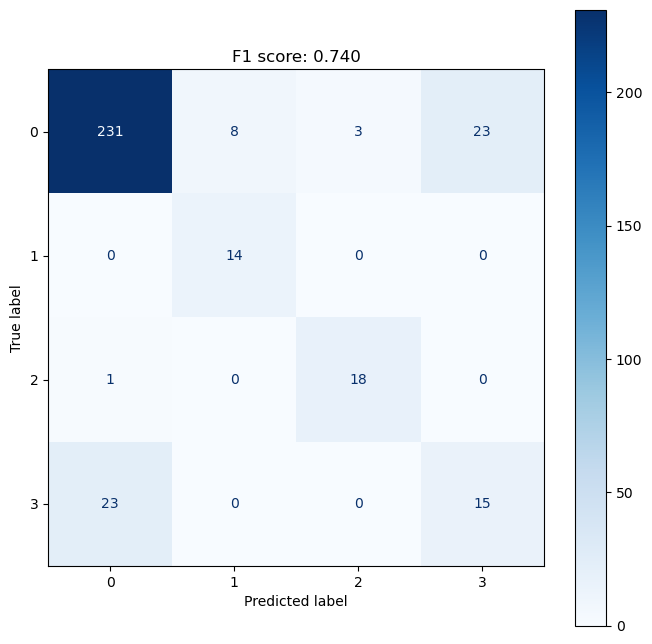

In [57]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

# for i in range(8):
i = 6
keyval = f'subject_{i}'
df_val = dctSt[keyval]

df_tr = []
for k in dctSt.keys():
  if k != keyval:
    df_tr.append(dctSt[k])
df_tr = pd.concat(df_tr)

Xtr = df_tr.iloc[:, :-1]
ytr = df_tr.iloc[:, -1]

Xvl = df_val.iloc[:, :-1] 
yvl = df_val.iloc[:, -1]

scaler = StandardScaler()
Xtr_sc = scaler.fit_transform(Xtr.values)
Xvl_sc = scaler.transform(Xvl.values)

print(f'*************************   Validation with subject {i}   *************************\n')
net = NetWrapper(10_000, learning_rate, device, None)
dfhist, minLoss, bestModel = net.fit(Xtr_sc, ytr.values, Xvl_sc, yvl.values)

pred = net.predict(Xvl_sc).argmax(axis = 1)
m = confusion_matrix(yvl.values, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=m)
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax,  cmap = plt.cm.Blues)
ax.set_title(f"F1 score: {f1_score(pred, yvl.values, average='macro'):0.3f}")

Different balance threshold

In [64]:
dctClassBal = balanceData(dctClass, 2)

## randomly select values for the 2 mode classes to match the dctClassBal
dctUpsBal = {}
for k in dctUps.keys():
    dfk =  dctUps[k]
    out2 = []
    for s in dfk['session'].unique():
        dfks = dfk[dfk['session'] == s]

        nvalAll = dctClass[k].loc[s, :]
        nvalBall = dctClassBal[k].loc[s, :]
        
        out = []
        for c in nvalAll.index:
            dfksc = dfks[dfks['class'] == c]
            dfkscBal = dfks.sample(nvalBall.loc[c]).sort_index()
            out.append(dfkscBal)
        dfout = pd.concat(out).sort_index()
        out2.append(dfout)
    dctUpsBal[k] = pd.concat(out2)

## duplicate upsampled dictionary but with flags for the windows of each class in each session
## for each subject

wlength = 50
overlapping = 10
windows_size = []

dctSt = {}
for k in dctUpsBal.keys():
    df = dctUpsBal[k]
    list2 = []
    ## loop through sessions
    for s in df['session'].unique():
        dfs = df[df['session'] == s]
        d = 0
        for i in range(0, len(dfs) - overlapping, wlength - overlapping):
            dfss = dfs.iloc[i:i + wlength]
            list1 = []
            for ic, c in enumerate(dfss.columns[:6]):
                dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                list1.extend(dummy)
            list1.append(int(dfss['class'].mode().iloc[0]))
            list2.append(list1)
    dctSt[k] = pd.DataFrame(data = list2)

dfsum_bal = []
for key in dctClassBal.keys():
    dfsum_bal.append(dctClassBal[key].sum())

dfsum_bal = pd.DataFrame(index = dctClassBal.keys(), columns = dctClassBal['subject_1'].columns, data = dfsum_bal)
weights_bal = (dfsum_bal.sum()/dfsum_bal.sum().sum()).values
print(weights_bal)

[0.33983884 0.14713594 0.19470677 0.31831845]


*************************   Validation with subject 6   *************************

Epoch 0/20000. Training loss: 1.411 - Validation loss: 1.402
Epoch 1000/20000. Training loss: 0.823 - Validation loss: 0.935
Epoch 2000/20000. Training loss: 0.773 - Validation loss: 0.906
Epoch 3000/20000. Training loss: 0.762 - Validation loss: 0.918
Epoch 4000/20000. Training loss: 0.759 - Validation loss: 0.909
Epoch 5000/20000. Training loss: 0.756 - Validation loss: 0.913
Epoch 6000/20000. Training loss: 0.754 - Validation loss: 0.910
Epoch 7000/20000. Training loss: 0.754 - Validation loss: 0.910
Epoch 8000/20000. Training loss: 0.753 - Validation loss: 0.903
Epoch 9000/20000. Training loss: 0.753 - Validation loss: 0.913
Epoch 10000/20000. Training loss: 0.752 - Validation loss: 0.907
Epoch 11000/20000. Training loss: 0.752 - Validation loss: 0.903
Epoch 12000/20000. Training loss: 0.752 - Validation loss: 0.911
Epoch 13000/20000. Training loss: 0.752 - Validation loss: 0.913
Epoch 14000/20000. T

Text(0.5, 1.0, 'F1 score: 0.779')

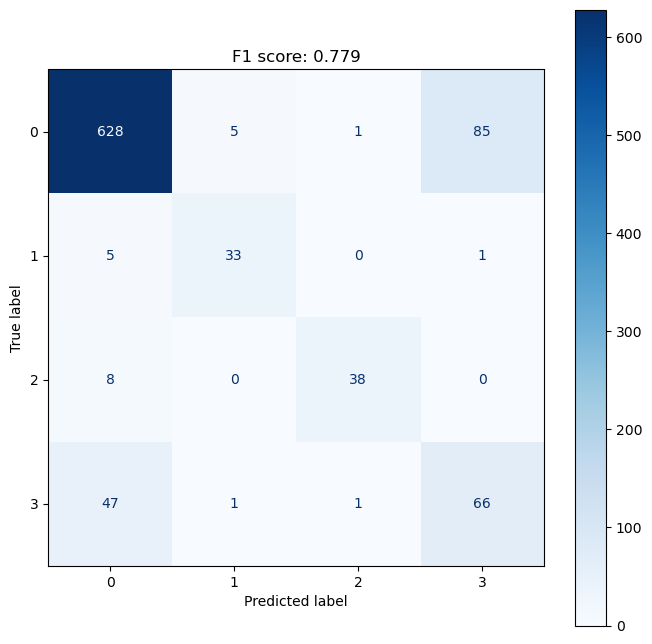

In [65]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

# for i in range(8):
i = 6
keyval = f'subject_{i}'
df_val = dctSt[keyval]

df_tr = []
for k in dctSt.keys():
  if k != keyval:
    df_tr.append(dctSt[k])
df_tr = pd.concat(df_tr)

Xtr = df_tr.iloc[:, :-1]
ytr = df_tr.iloc[:, -1]

Xvl = df_val.iloc[:, :-1] 
yvl = df_val.iloc[:, -1]

scaler = StandardScaler()
Xtr_sc = scaler.fit_transform(Xtr.values)
Xvl_sc = scaler.transform(Xvl.values)

print(f'*************************   Validation with subject {i}   *************************\n')
net = NetWrapper(20_000, learning_rate, device, None)
dfhist, minLoss, bestModel = net.fit(Xtr_sc, ytr.values, Xvl_sc, yvl.values)

pred = net.predict(Xvl_sc).argmax(axis = 1)
m = confusion_matrix(yvl.values, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=m)
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax,  cmap = plt.cm.Blues)
ax.set_title(f"F1 score: {f1_score(pred, yvl.values, average='macro'):0.3f}")

In [71]:
dctClassBal = balanceData(dctClass, 2)

## randomly select values for the 2 mode classes to match the dctClassBal
dctUpsBal = {}
for k in dctUps.keys():
    dfk =  dctUps[k]
    out2 = []
    for s in dfk['session'].unique():
        dfks = dfk[dfk['session'] == s]

        nvalAll = dctClass[k].loc[s, :]
        nvalBall = dctClassBal[k].loc[s, :]
        
        out = []
        for c in nvalAll.index:
            dfksc = dfks[dfks['class'] == c]
            dfkscBal = dfks.sample(nvalBall.loc[c]).sort_index()
            out.append(dfkscBal)
        dfout = pd.concat(out).sort_index()
        out2.append(dfout)
    dctUpsBal[k] = pd.concat(out2)

## duplicate upsampled dictionary but with flags for the windows of each class in each session
## for each subject

wlength = 50
overlapping = 5
windows_size = []

dctSt = {}
for k in dctUpsBal.keys():
    df = dctUpsBal[k]
    list2 = []
    ## loop through sessions
    for s in df['session'].unique():
        dfs = df[df['session'] == s]
        d = 0
        for i in range(0, len(dfs) - overlapping, wlength - overlapping):
            dfss = dfs.iloc[i:i + wlength]
            list1 = []
            for ic, c in enumerate(dfss.columns[:6]):
                dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                list1.extend(dummy)
            list1.append(int(dfss['class'].mode().iloc[0]))
            list2.append(list1)
    dctSt[k] = pd.DataFrame(data = list2)

dfsum_bal = []
for key in dctClassBal.keys():
    dfsum_bal.append(dctClassBal[key].sum())

dfsum_bal = pd.DataFrame(index = dctClassBal.keys(), columns = dctClassBal['subject_1'].columns, data = dfsum_bal)
weights_bal = (dfsum_bal.sum()/dfsum_bal.sum().sum()).values
print(weights_bal)

[0.33983884 0.14713594 0.19470677 0.31831845]


*************************   Validation with subject 6   *************************

Epoch 0/10000. Training loss: 1.406 - Validation loss: 1.409
Epoch 1000/10000. Training loss: 0.820 - Validation loss: 0.987
Epoch 2000/10000. Training loss: 0.777 - Validation loss: 0.953
Epoch 3000/10000. Training loss: 0.766 - Validation loss: 0.957
Epoch 4000/10000. Training loss: 0.759 - Validation loss: 0.955
Epoch 5000/10000. Training loss: 0.757 - Validation loss: 0.951
Epoch 6000/10000. Training loss: 0.756 - Validation loss: 0.942
Epoch 7000/10000. Training loss: 0.755 - Validation loss: 0.951
Epoch 8000/10000. Training loss: 0.754 - Validation loss: 0.944
Epoch 9000/10000. Training loss: 0.754 - Validation loss: 0.945


Text(0.5, 1.0, 'F1 score: 0.762')

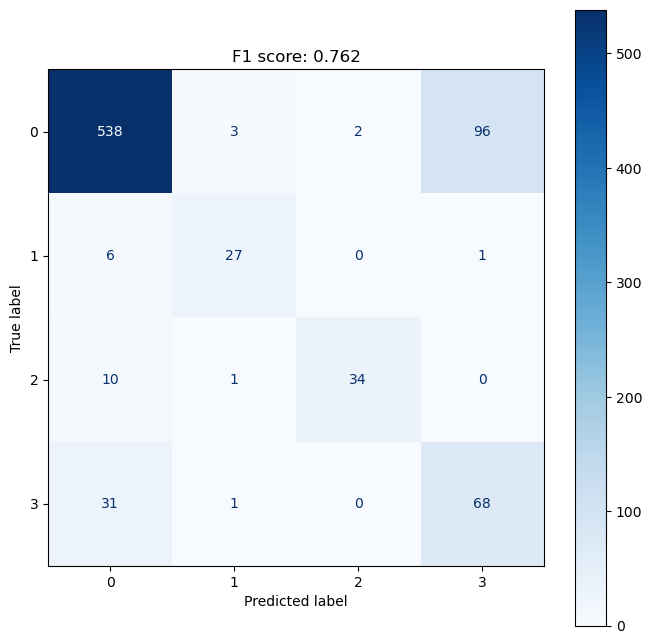

In [72]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

# for i in range(8):
i = 6
keyval = f'subject_{i}'
df_val = dctSt[keyval]

df_tr = []
for k in dctSt.keys():
  if k != keyval:
    df_tr.append(dctSt[k])
df_tr = pd.concat(df_tr)

Xtr = df_tr.iloc[:, :-1]
ytr = df_tr.iloc[:, -1]

Xvl = df_val.iloc[:, :-1] 
yvl = df_val.iloc[:, -1]

scaler = StandardScaler()
Xtr_sc = scaler.fit_transform(Xtr.values)
Xvl_sc = scaler.transform(Xvl.values)

print(f'*************************   Validation with subject {i}   *************************\n')
net = NetWrapper(10_000, learning_rate, device, None)
dfhist, minLoss, bestModel = net.fit(Xtr_sc, ytr.values, Xvl_sc, yvl.values)

pred = net.predict(Xvl_sc).argmax(axis = 1)
m = confusion_matrix(yvl.values, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=m)
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax,  cmap = plt.cm.Blues)
ax.set_title(f"F1 score: {f1_score(pred, yvl.values, average='macro'):0.3f}")

In [73]:
dctClassBal = balanceData(dctClass, 2)

## randomly select values for the 2 mode classes to match the dctClassBal
dctUpsBal = {}
for k in dctUps.keys():
    dfk =  dctUps[k]
    out2 = []
    for s in dfk['session'].unique():
        dfks = dfk[dfk['session'] == s]

        nvalAll = dctClass[k].loc[s, :]
        nvalBall = dctClassBal[k].loc[s, :]
        
        out = []
        for c in nvalAll.index:
            dfksc = dfks[dfks['class'] == c]
            dfkscBal = dfks.sample(nvalBall.loc[c]).sort_index()
            out.append(dfkscBal)
        dfout = pd.concat(out).sort_index()
        out2.append(dfout)
    dctUpsBal[k] = pd.concat(out2)

## duplicate upsampled dictionary but with flags for the windows of each class in each session
## for each subject

wlength = 25
overlapping = 5
windows_size = []

dctSt = {}
for k in dctUpsBal.keys():
    df = dctUpsBal[k]
    list2 = []
    ## loop through sessions
    for s in df['session'].unique():
        dfs = df[df['session'] == s]
        d = 0
        for i in range(0, len(dfs) - overlapping, wlength - overlapping):
            dfss = dfs.iloc[i:i + wlength]
            list1 = []
            for ic, c in enumerate(dfss.columns[:6]):
                dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                list1.extend(dummy)
            list1.append(int(dfss['class'].mode().iloc[0]))
            list2.append(list1)
    dctSt[k] = pd.DataFrame(data = list2)

dfsum_bal = []
for key in dctClassBal.keys():
    dfsum_bal.append(dctClassBal[key].sum())

dfsum_bal = pd.DataFrame(index = dctClassBal.keys(), columns = dctClassBal['subject_1'].columns, data = dfsum_bal)
weights_bal = (dfsum_bal.sum()/dfsum_bal.sum().sum()).values
print(weights_bal)

[0.33983884 0.14713594 0.19470677 0.31831845]


*************************   Validation with subject 6   *************************

Epoch 0/10000. Training loss: 1.404 - Validation loss: 1.412
Epoch 1000/10000. Training loss: 0.856 - Validation loss: 0.926
Epoch 2000/10000. Training loss: 0.804 - Validation loss: 0.917
Epoch 3000/10000. Training loss: 0.787 - Validation loss: 0.913
Epoch 4000/10000. Training loss: 0.780 - Validation loss: 0.910
Epoch 5000/10000. Training loss: 0.774 - Validation loss: 0.915
Epoch 6000/10000. Training loss: 0.771 - Validation loss: 0.915
Epoch 7000/10000. Training loss: 0.767 - Validation loss: 0.918
Epoch 8000/10000. Training loss: 0.767 - Validation loss: 0.910
Epoch 9000/10000. Training loss: 0.765 - Validation loss: 0.908


Text(0.5, 1.0, 'F1 score: 0.765')

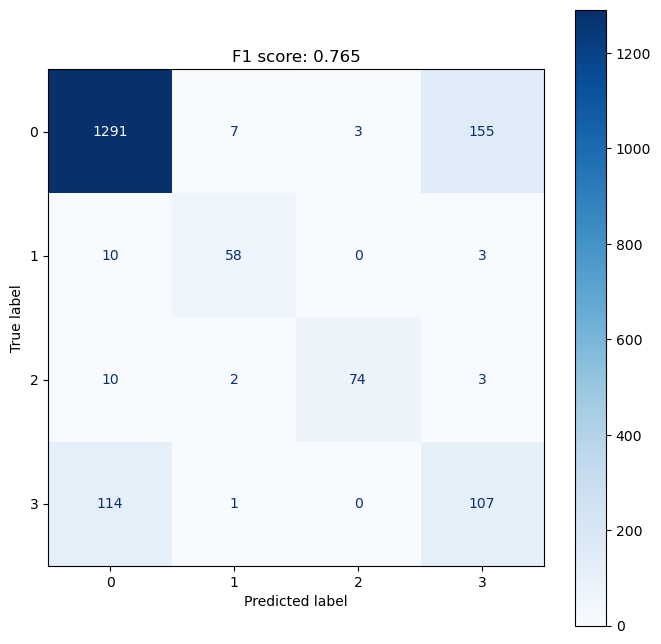

In [74]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

# for i in range(8):
i = 6
keyval = f'subject_{i}'
df_val = dctSt[keyval]

df_tr = []
for k in dctSt.keys():
  if k != keyval:
    df_tr.append(dctSt[k])
df_tr = pd.concat(df_tr)

Xtr = df_tr.iloc[:, :-1]
ytr = df_tr.iloc[:, -1]

Xvl = df_val.iloc[:, :-1] 
yvl = df_val.iloc[:, -1]

scaler = StandardScaler()
Xtr_sc = scaler.fit_transform(Xtr.values)
Xvl_sc = scaler.transform(Xvl.values)

print(f'*************************   Validation with subject {i}   *************************\n')
net = NetWrapper(10_000, learning_rate, device, None)
dfhist, minLoss, bestModel = net.fit(Xtr_sc, ytr.values, Xvl_sc, yvl.values)

pred = net.predict(Xvl_sc).argmax(axis = 1)
m = confusion_matrix(yvl.values, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=m)
fig, ax = plt.subplots(figsize = (8, 8))
disp.plot(ax = ax,  cmap = plt.cm.Blues)
ax.set_title(f"F1 score: {f1_score(pred, yvl.values, average='macro'):0.3f}")



*************************   Hyperparameters (2, 25, 5)   *************************

Epoch 0/10000. Training loss: 1.367 - Validation loss: 1.368
Epoch 1000/10000. Training loss: 0.850 - Validation loss: 0.940
Epoch 2000/10000. Training loss: 0.801 - Validation loss: 0.925
Epoch 3000/10000. Training loss: 0.784 - Validation loss: 0.920
Epoch 4000/10000. Training loss: 0.776 - Validation loss: 0.929
Epoch 5000/10000. Training loss: 0.771 - Validation loss: 0.931
Epoch 6000/10000. Training loss: 0.767 - Validation loss: 0.926
Epoch 7000/10000. Training loss: 0.766 - Validation loss: 0.922
Epoch 8000/10000. Training loss: 0.765 - Validation loss: 0.927
Epoch 9000/10000. Training loss: 0.763 - Validation loss: 0.920


*************************   Hyperparameters (2, 50, 5)   *************************

Epoch 0/10000. Training loss: 1.396 - Validation loss: 1.390
Epoch 1000/10000. Training loss: 0.819 - Validation loss: 1.001
Epoch 2000/10000. Training loss: 0.774 - Validation loss: 0.983
Ep

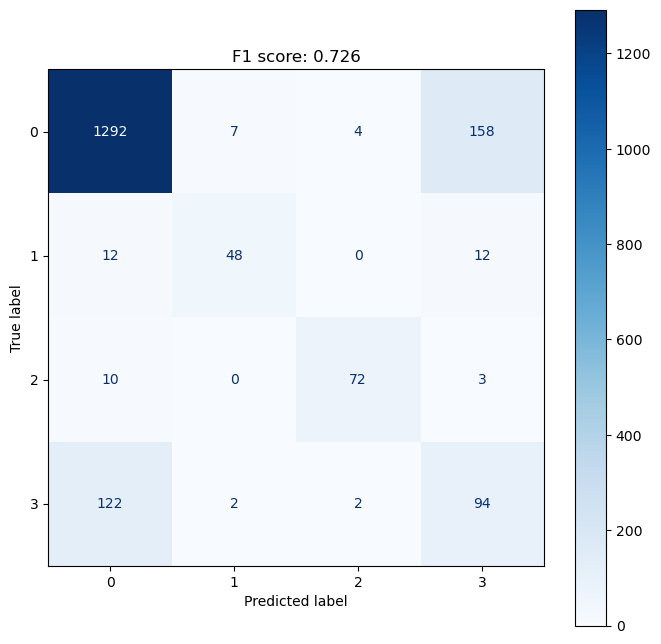

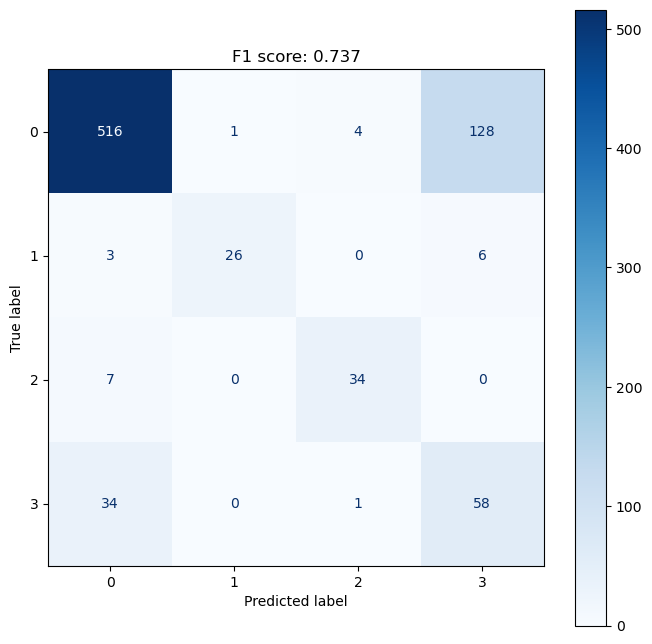

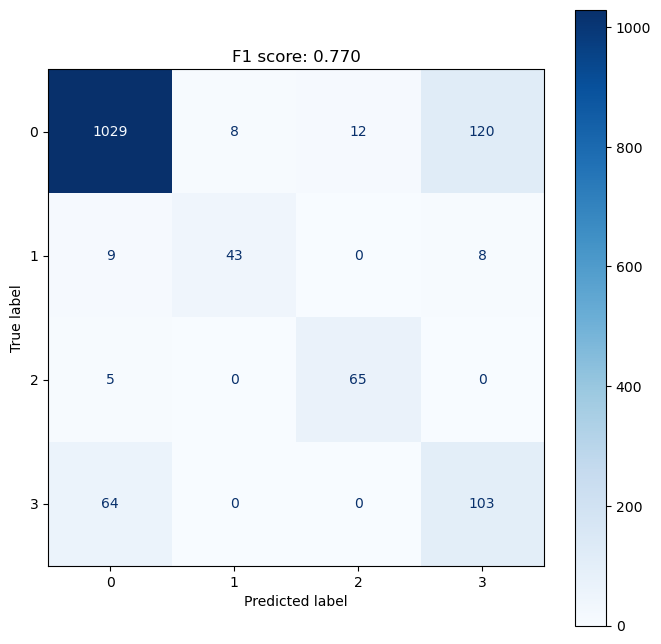

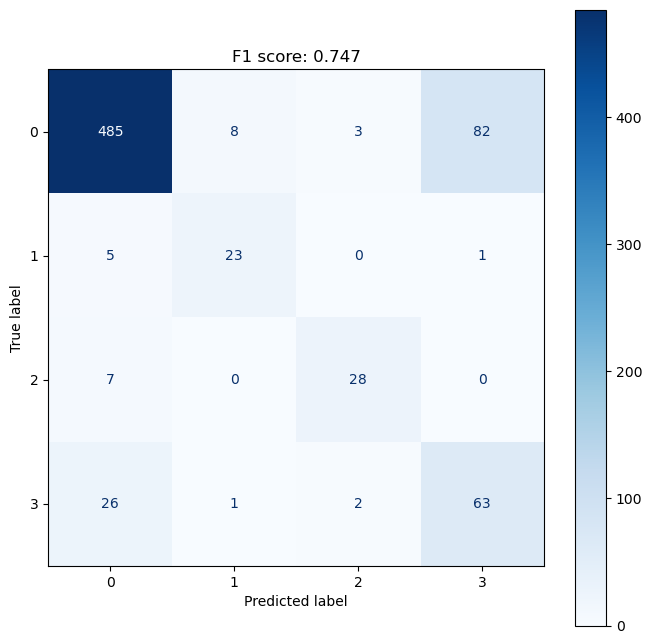

In [9]:
convs = [(2, 25, 5), (2, 50, 5), (2, 75, 50), (2, 100, 50)]


for co in convs:

    dctClassBal = balanceData(dctClass, co[0])

    ## randomly select values for the 2 mode classes to match the dctClassBal
    dctUpsBal = {}
    for k in dctUps.keys():
        dfk =  dctUps[k]
        out2 = []
        for s in dfk['session'].unique():
            dfks = dfk[dfk['session'] == s]

            nvalAll = dctClass[k].loc[s, :]
            nvalBall = dctClassBal[k].loc[s, :]
            
            out = []
            for c in nvalAll.index:
                dfksc = dfks[dfks['class'] == c]
                dfkscBal = dfks.sample(nvalBall.loc[c]).sort_index()
                out.append(dfkscBal)
            dfout = pd.concat(out).sort_index()
            out2.append(dfout)
        dctUpsBal[k] = pd.concat(out2)

    ## duplicate upsampled dictionary but with flags for the windows of each class in each session
    ## for each subject

    wlength = co[1]
    overlapping = co[2]
    windows_size = []

    dctSt = {}
    for k in dctUpsBal.keys():
        df = dctUpsBal[k]
        list2 = []
        ## loop through sessions
        for s in df['session'].unique():
            dfs = df[df['session'] == s]
            d = 0
            for i in range(0, len(dfs) - overlapping, wlength - overlapping):
                dfss = dfs.iloc[i:i + wlength]
                list1 = []
                for ic, c in enumerate(dfss.columns[:6]):
                    dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                    list1.extend(dummy)
                list1.append(int(dfss['class'].mode().iloc[0]))
                list2.append(list1)
        dctSt[k] = pd.DataFrame(data = list2)

    dfsum_bal = []
    for key in dctClassBal.keys():
        dfsum_bal.append(dctClassBal[key].sum())

    dfsum_bal = pd.DataFrame(index = dctClassBal.keys(), columns = dctClassBal['subject_1'].columns, data = dfsum_bal)
    weights_bal = (dfsum_bal.sum()/dfsum_bal.sum().sum()).values

    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    learning_rate = 1e-4

    # for i in range(8):
    i = 6
    keyval = f'subject_{i}'
    df_val = dctSt[keyval]

    df_tr = []
    for k in dctSt.keys():
        if k != keyval:
            df_tr.append(dctSt[k])
    df_tr = pd.concat(df_tr)

    Xtr = df_tr.iloc[:, :-1]
    ytr = df_tr.iloc[:, -1]

    Xvl = df_val.iloc[:, :-1] 
    yvl = df_val.iloc[:, -1]

    scaler = StandardScaler()
    Xtr_sc = scaler.fit_transform(Xtr.values)
    Xvl_sc = scaler.transform(Xvl.values)
    print('\n')
    print(f'*************************   Hyperparameters {co}   *************************\n')
    net = NetWrapper(10_000, learning_rate, device, None)
    dfhist, minLoss, bestModel = net.fit(Xtr_sc, ytr.values, Xvl_sc, yvl.values)

    pred = net.predict(Xvl_sc).argmax(axis = 1)
    m = confusion_matrix(yvl.values, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=m)
    fig, ax = plt.subplots(figsize = (8, 8))
    disp.plot(ax = ax,  cmap = plt.cm.Blues)
    ax.set_title(f"F1 score: {f1_score(pred, yvl.values, average='macro'):0.3f}")

Epoch 0/10000. Training loss: 1.411 - Validation loss: 1.399
Epoch 1000/10000. Training loss: 0.808 - Validation loss: 0.979
Epoch 2000/10000. Training loss: 0.764 - Validation loss: 0.952
Epoch 3000/10000. Training loss: 0.756 - Validation loss: 0.950
Epoch 4000/10000. Training loss: 0.752 - Validation loss: 0.954
Epoch 5000/10000. Training loss: 0.751 - Validation loss: 0.942
Epoch 6000/10000. Training loss: 0.749 - Validation loss: 0.955
Epoch 7000/10000. Training loss: 0.749 - Validation loss: 0.951
Epoch 8000/10000. Training loss: 0.748 - Validation loss: 0.942
Epoch 9000/10000. Training loss: 0.748 - Validation loss: 0.945
Epoch 0/10000. Training loss: 1.400 - Validation loss: 1.384
Epoch 1000/10000. Training loss: 0.812 - Validation loss: 0.990
Epoch 2000/10000. Training loss: 0.768 - Validation loss: 0.979
Epoch 3000/10000. Training loss: 0.758 - Validation loss: 0.985
Epoch 4000/10000. Training loss: 0.754 - Validation loss: 0.982
Epoch 5000/10000. Training loss: 0.752 - Valid

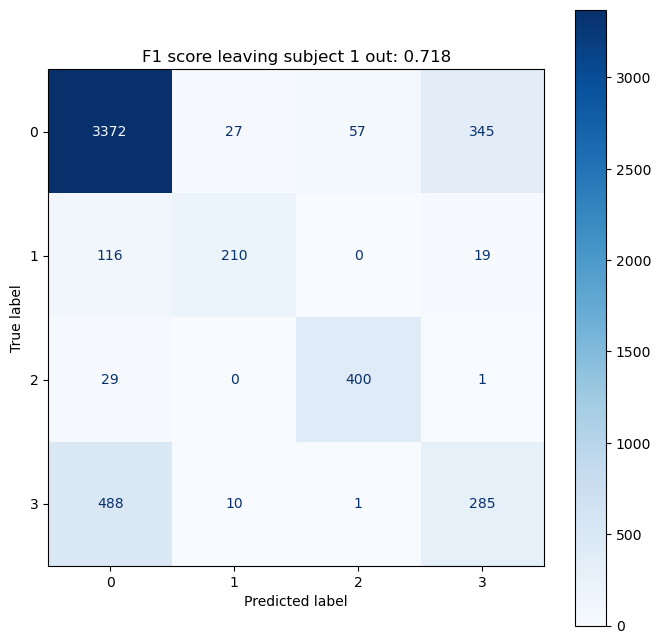

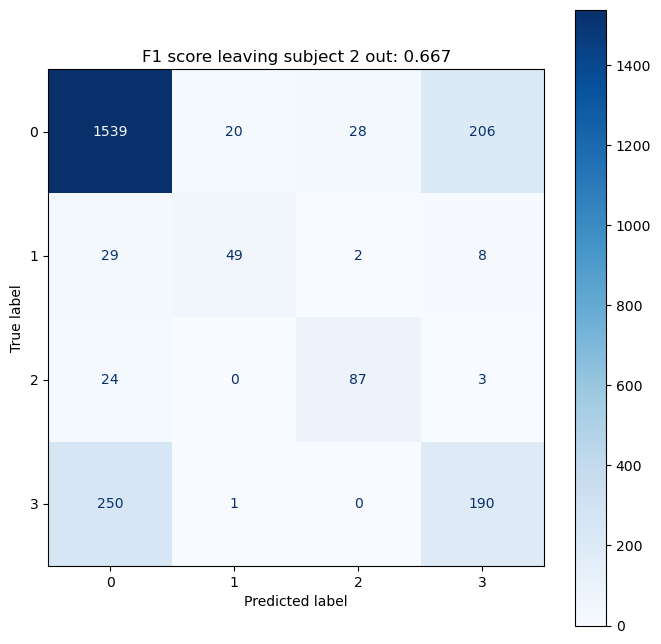

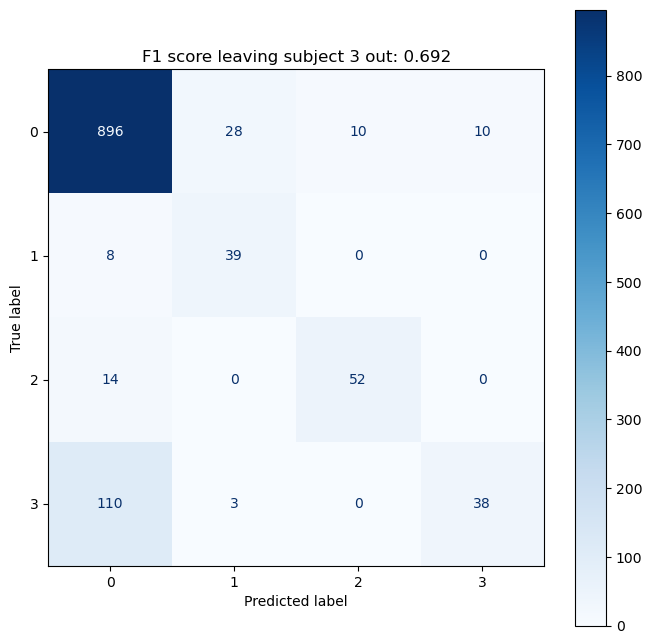

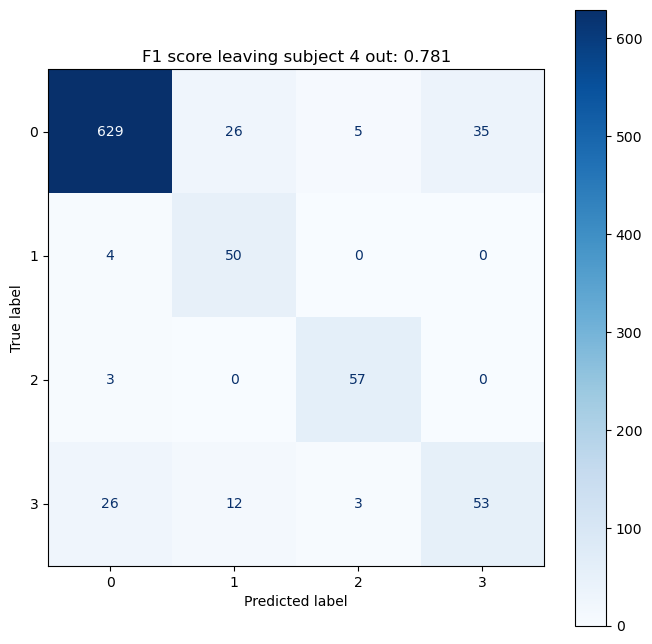

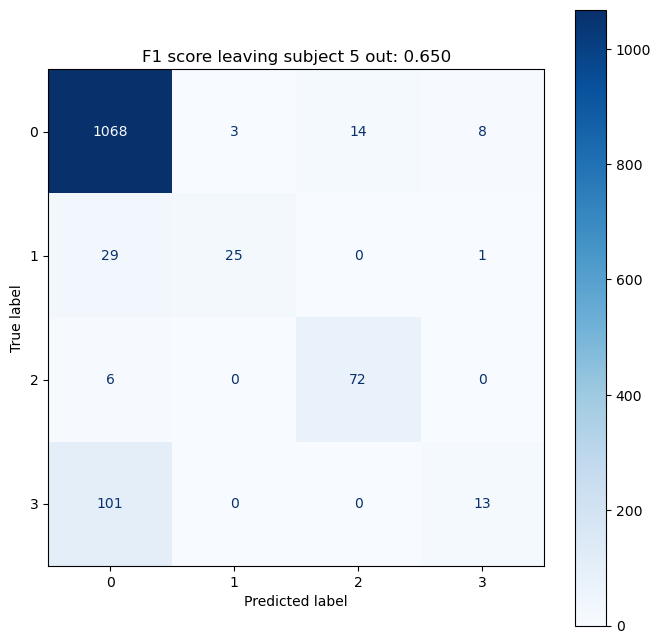

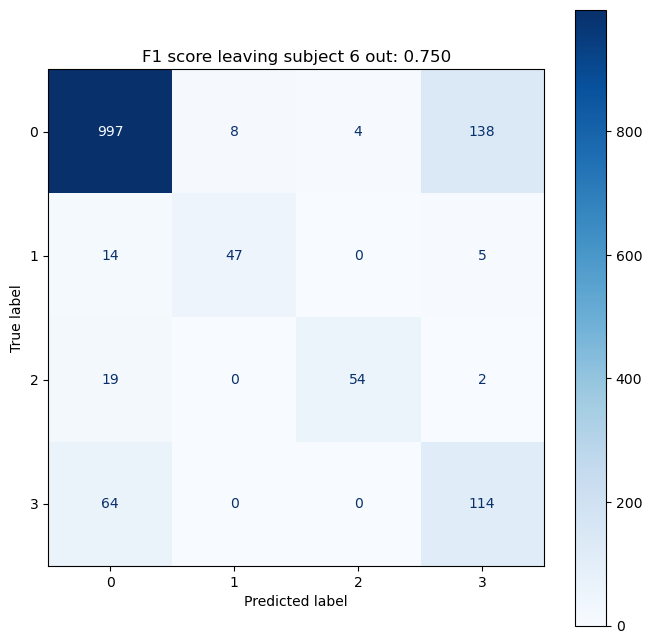

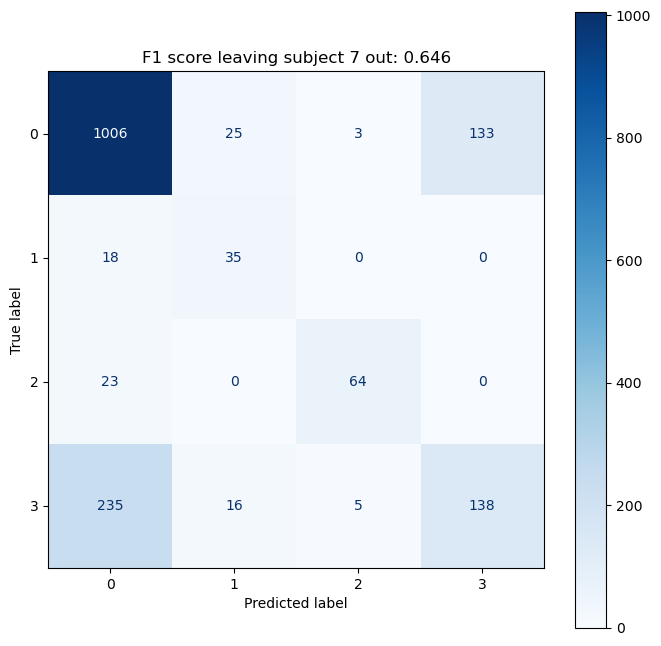

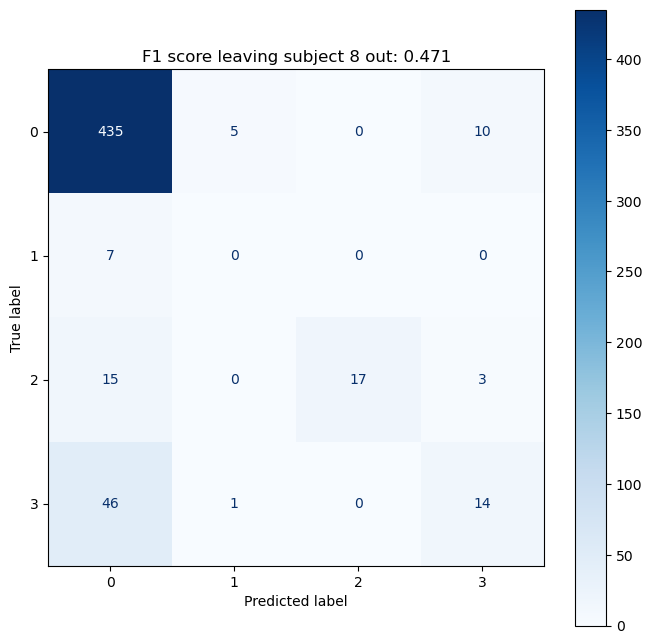

In [13]:
co = (2, 75, 50)

dctClassBal = balanceData(dctClass, co[0])

## randomly select values for the 2 mode classes to match the dctClassBal
dctUpsBal = {}
for k in dctUps.keys():
    dfk =  dctUps[k]
    out2 = []
    for s in dfk['session'].unique():
        dfks = dfk[dfk['session'] == s]

        nvalAll = dctClass[k].loc[s, :]
        nvalBall = dctClassBal[k].loc[s, :]
        
        out = []
        for c in nvalAll.index:
            dfksc = dfks[dfks['class'] == c]
            dfkscBal = dfks.sample(nvalBall.loc[c]).sort_index()
            out.append(dfkscBal)
        dfout = pd.concat(out).sort_index()
        out2.append(dfout)
    dctUpsBal[k] = pd.concat(out2)

## duplicate upsampled dictionary but with flags for the windows of each class in each session
## for each subject

wlength = co[1]
overlapping = co[2]
windows_size = []

dctSt = {}
for k in dctUpsBal.keys():
    df = dctUpsBal[k]
    list2 = []
    ## loop through sessions
    for s in df['session'].unique():
        dfs = df[df['session'] == s]
        d = 0
        for i in range(0, len(dfs) - overlapping, wlength - overlapping):
            dfss = dfs.iloc[i:i + wlength]
            list1 = []
            for ic, c in enumerate(dfss.columns[:6]):
                dummy = list(dfss[c].quantile(np.arange(0, 1.1, 0.1)))
                list1.extend(dummy)
            list1.append(int(dfss['class'].mode().iloc[0]))
            list2.append(list1)
    dctSt[k] = pd.DataFrame(data = list2)

dfsum_bal = []
for key in dctClassBal.keys():
    dfsum_bal.append(dctClassBal[key].sum())

dfsum_bal = pd.DataFrame(index = dctClassBal.keys(), columns = dctClassBal['subject_1'].columns, data = dfsum_bal)
weights_bal = (dfsum_bal.sum()/dfsum_bal.sum().sum()).values

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4

for i in range(1, 9):
# i = 6
    keyval = f'subject_{i}'
    df_val = dctSt[keyval]

    df_tr = []
    for k in dctSt.keys():
        if k != keyval:
            df_tr.append(dctSt[k])
    df_tr = pd.concat(df_tr)

    Xtr = df_tr.iloc[:, :-1]
    ytr = df_tr.iloc[:, -1]

    Xvl = df_val.iloc[:, :-1] 
    yvl = df_val.iloc[:, -1]

    scaler = StandardScaler()
    Xtr_sc = scaler.fit_transform(Xtr.values)
    Xvl_sc = scaler.transform(Xvl.values)

    net = NetWrapper(10_000, learning_rate, device, None)
    dfhist, minLoss, bestModel = net.fit(Xtr_sc, ytr.values, Xvl_sc, yvl.values)

    pred = net.predict(Xvl_sc).argmax(axis = 1)
    m = confusion_matrix(yvl.values, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=m)
    fig, ax = plt.subplots(figsize = (8, 8))
    disp.plot(ax = ax,  cmap = plt.cm.Blues)
    ax.set_title(f"F1 score leaving subject {i} out: {f1_score(pred, yvl.values, average='macro'):0.3f}")

Ensemble the models in case we decide to go with this

In [11]:
def ensemble_predict(inputs):
    outputs = []
    with torch.no_grad():
        # get the predictions of each individual model
        outputs.append(model1(inputs))
        outputs.append(model2(inputs))
        outputs.append(model3(inputs))
        outputs.append(model4(inputs))
        outputs.append(model5(inputs))
        outputs.append(model6(inputs))
        outputs.append(model7(inputs))
        outputs.append(model8(inputs))
        
        # take the average of the outputs
        outputs = torch.stack(outputs).mean(dim=0)
        
        # return the class with the highest probability
        _, predicted = torch.max(outputs, 1)
    return predicted


dict_keys(['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8'])